In [1]:
from config import pickle_file
import pickle
with open(pickle_file, 'rb') as file:
    data = pickle.load(file)

In [2]:
keys = list(data.keys())
print(keys)

['VOCAB', 'IVOCAB', 'train', 'dev', 'test']


In [3]:
print('train:'+str(len(data['train'])))
print('dev:'+str(len(data['dev'])))
print('test:'+str(len(data['test'])))
print('vocab_size:' + str(len(data['VOCAB'])))

train:120098
dev:14326
test:7176
vocab_size:4336


In [4]:
char_list = data['IVOCAB']
print(char_list)
number_list = data['VOCAB']
print(number_list)

{0: '<PAD>', 1: '<sos>', 2: '<eos>', 3: '而', 4: '对', 5: '楼', 6: '市', 7: '成', 8: '交', 9: '抑', 10: '制', 11: '作', 12: '用', 13: '最', 14: '大', 15: '的', 16: '限', 17: '购', 18: '也', 19: '为', 20: '地', 21: '方', 22: '政', 23: '府', 24: '眼', 25: '中', 26: '钉', 27: '自', 28: '六', 29: '月', 30: '底', 31: '呼', 32: '和', 33: '浩', 34: '特', 35: '率', 36: '先', 37: '宣', 38: '布', 39: '取', 40: '消', 41: '后', 42: '各', 43: '便', 44: '纷', 45: '跟', 46: '进', 47: '仅', 48: '一', 49: '个', 50: '多', 51: '时', 52: '间', 53: '里', 54: '除', 55: '了', 56: '北', 57: '京', 58: '上', 59: '海', 60: '广', 61: '州', 62: '深', 63: '圳', 64: '四', 65: '线', 66: '城', 67: '三', 68: '亚', 69: '之', 70: '外', 71: '十', 72: '当', 73: '已', 74: '正', 75: '式', 76: '或', 77: '变', 78: '相', 79: '放', 80: '松', 81: '财', 82: '金', 83: '融', 84: '策', 85: '紧', 86: '随', 87: '其', 88: '来', 89: '显', 90: '示', 91: '出', 92: '极', 93: '强', 94: '威', 95: '力', 96: '与', 97: '往', 98: '需', 99: '求', 100: '密', 101: '切', 102: '关', 103: '房', 104: '贷', 105: '包', 106: '括', 107: '拥', 108: '有', 109: '套

In [5]:
print(data['train'][0].keys())

dict_keys(['trn', 'wave'])


In [6]:
print(data['train'][0])
merged_sentence = ''.join(data['train'][0]['trn'])
print(merged_sentence)

{'trn': ['而', '对', '楼', '市', '成', '交', '抑', '制', '作', '用', '最', '大', '的', '限', '购'], 'wave': '../dataset/data_aishell/wav\\train\\S0002\\BAC009S0002W0122.wav'}
而对楼市成交抑制作用最大的限购


In [7]:
# char_list值是文字,number_list值是数字
char_list = data['IVOCAB']
number_list = data['VOCAB']
print(char_list[3])
print(number_list['而'])

而
3


加载声音

In [8]:
import librosa
import numpy as np
import random
sample_rate=16000
seed=111
# 遮盖次数
num_mask=2
# 频率维度遮盖最大比例
freq_masking_max_percentage=0.15
# 时间维度遮盖最大比例
time_masking_max_percentage=0.3
# 预处理添加跳帧和堆叠
LFR_stack=4
LFR_skip=3
d_feature=80
def normalize(yt):
    yt_max = np.max(yt)
    yt_min = np.min(yt)
    a = 1.0 / (yt_max - yt_min)
    b = -(yt_max + yt_min) / (2 * (yt_max - yt_min))

    yt = yt * a + b
    return yt
def extract_feature(input_file, feature='fbank', dim=80, cmvn=True, delta=False, delta_delta=False,
                    window_size=25, stride=10, save_feature=None):
    y, sr = librosa.load(input_file, sr=sample_rate)
    yt, _ = librosa.effects.trim(y, top_db=20)
    yt = normalize(yt)
    ws = int(sr * 0.001 * window_size)
    st = int(sr * 0.001 * stride)
    if feature == 'fbank':  # log-scaled
        feat = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=dim,
                                              n_fft=ws, hop_length=st)
        feat = np.log(feat + 1e-6)
        
        
        
    elif feature == 'mfcc':
        feat = librosa.feature.mfcc(y=yt, sr=sr, n_mfcc=dim, n_mels=26,
                                    n_fft=ws, hop_length=st)
        feat[0] = librosa.feature.rmse(yt, hop_length=st, frame_length=ws)

    else:
        raise ValueError('Unsupported Acoustic Feature: ' + feature)

    feat = [feat]
    if delta:
        feat.append(librosa.feature.delta(feat[0]))

    if delta_delta:
        feat.append(librosa.feature.delta(feat[0], order=2))
    feat = np.concatenate(feat, axis=0)
    if cmvn:
        feat = (feat - feat.mean(axis=1)[:, np.newaxis]) / (feat.std(axis=1) + 1e-16)[:, np.newaxis]
    if save_feature is not None:
        tmp = np.swapaxes(feat, 0, 1).astype('float32')
        np.save(save_feature, tmp)
        return len(tmp)
    else:
        return np.swapaxes(feat, 0, 1).astype('float32')
random.seed(seed)
# 在时空上添加噪声
def spec_augment(spec: np.ndarray, num_mask=num_mask, 
                 freq_masking_max_percentage=freq_masking_max_percentage, time_masking_max_percentage=time_masking_max_percentage):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0

    return spec

def build_LFR_features(inputs, m=LFR_stack, n=LFR_skip):
    """
    Actually, this implements stacking frames and skipping frames.
    if m = 1 and n = 1, just return the origin features.
    if m = 1 and n > 1, it works like skipping.
    if m > 1 and n = 1, it works like stacking but only support right frames.
    if m > 1 and n > 1, it works like LFR.
    Args:
        inputs_batch: inputs is T x D np.ndarray
        m: number of frames to stack
        n: number of frames to skip
    """
    # LFR_inputs_batch = []
    # for inputs in inputs_batch:
    LFR_inputs = []
    T = inputs.shape[0]
    T_lfr = int(np.ceil(T / n))
    for i in range(T_lfr):
        if m <= T - i * n:
            LFR_inputs.append(np.hstack(inputs[i * n:i * n + m]))
        else:  # process last LFR frame
            num_padding = m - (T - i * n)
            frame = np.hstack(inputs[i * n:])
            for _ in range(num_padding):
                frame = np.hstack((frame, inputs[-1]))
            LFR_inputs.append(frame)
    return np.vstack(LFR_inputs)

In [9]:
print(data['train'][0]['trn'])
print(data['train'][0]['wave'])

['而', '对', '楼', '市', '成', '交', '抑', '制', '作', '用', '最', '大', '的', '限', '购']
../dataset/data_aishell/wav\train\S0002\BAC009S0002W0122.wav


In [10]:
feature=extract_feature(input_file=data['train'][3]['wave'], feature='fbank', dim=d_feature, cmvn=True)
feature = (feature - feature.mean()) / feature.std()
feature=spec_augment(feature)
feature=build_LFR_features(feature)  #m=4 n=3
featurem10n1=build_LFR_features(feature,m=10,n=1)
featurem1n1=build_LFR_features(feature,m=1,n=1)
featurem1n1=build_LFR_features(feature,m=1,n=1)
featurem1n10=build_LFR_features(feature,m=1,n=10)

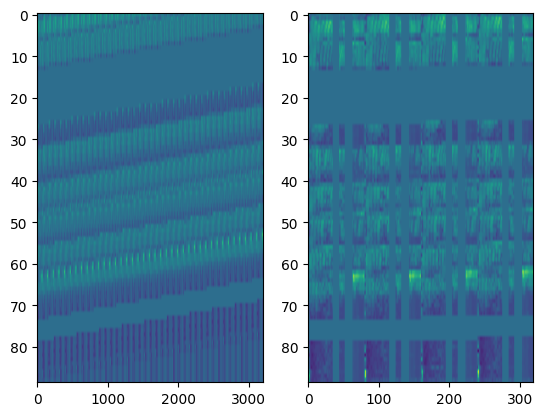

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
plt.imshow(featurem10n1,aspect= 'auto')
plt.subplot(1,2,2)
plt.imshow(featurem1n1,aspect= 'auto')
plt.show()

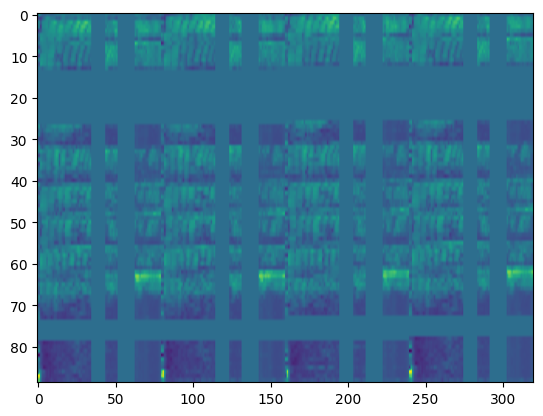

In [12]:
plt.figure()
plt.imshow(featurem1n1,aspect= 'auto')
plt.show()

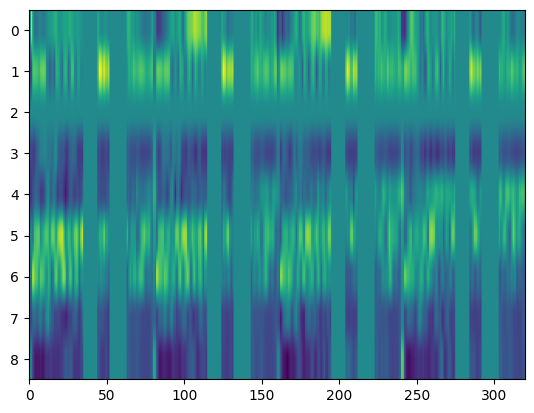

In [13]:
plt.figure()
plt.imshow(featurem1n10,aspect= 'auto')
plt.show()

In [14]:
feature2=extract_feature(input_file=data['train'][0]['wave'], feature='fbank', dim=d_feature, cmvn=True)
feature2 = (feature2 - feature2.mean()) / feature2.std()
feature2=build_LFR_features(feature2)

In [15]:
print(feature.shape)

(89, 320)


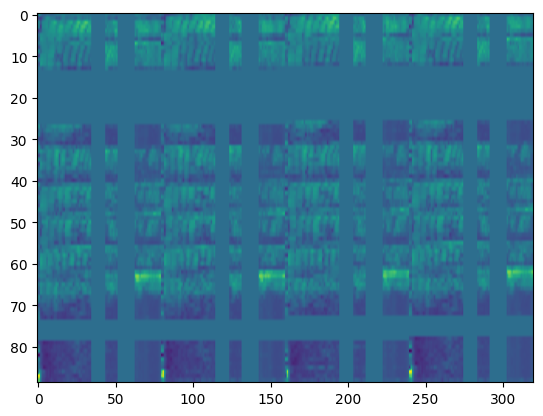

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(feature,aspect= 'auto')
plt.show()

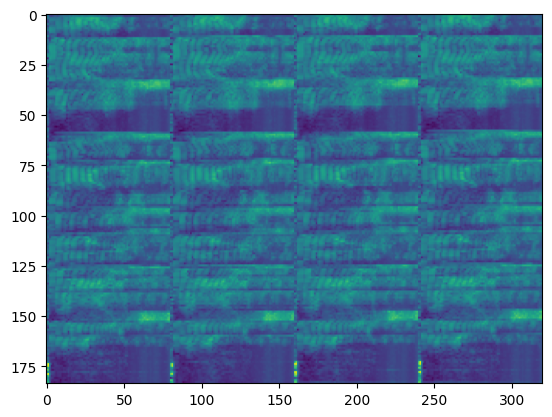

In [17]:
plt.figure()
plt.imshow(feature2,aspect= 'auto')
plt.show()

数据加载

In [18]:
from torch.utils.data import Dataset, DataLoader
# import torchvision.transforms as transforms
import torch
import numpy as np
max_sequence_length = 300
from torch.utils.data.dataloader import default_collate
def pad_collate(batch):
    max_input_len = float('-inf')
    max_target_len = float('-inf')

    for elem in batch:
        feature, trn = elem
        max_input_len = max_input_len if max_input_len > feature.shape[0] else feature.shape[0]
        max_target_len = max_target_len if max_target_len > len(trn) else len(trn)

    for i, elem in enumerate(batch):
        feature, trn = elem
        input_length = feature.shape[0]
        input_dim = feature.shape[1]
        padded_input = np.zeros((max_input_len, input_dim), dtype=np.float32)
        padded_input[:input_length, :] = feature
        batch[i] = (padded_input, trn, input_length)

    # sort it by input lengths (long to short)
    batch.sort(key=lambda x: x[2], reverse=True)

    return default_collate(batch)
class SpeechDataset(Dataset):
    def __init__(self,data_name):
        # data loading (data_name 是哪一个数据集)
        with open(pickle_file,'rb') as f:
            self.data=pickle.load(f)
        self.samples=data[data_name]
        self.n_samples=len(self.samples)
        # self.transform = transforms.Resize((max_sequence_length, 320))
    def __getitem__(self,index):
        # dataset[0]
        sample=self.samples[index]
        wave=sample['wave']
        trn=sample['trn']
        feature=extract_feature(input_file=wave, feature='fbank', dim=d_feature, cmvn=True)
        # 标准化
        feature = (feature - feature.mean()) / feature.std()
        # 添加噪声
        feature=spec_augment(feature)
        feature=build_LFR_features(feature)
        feature = torch.from_numpy(feature)
        # feature = torch.unsqueeze(feature, 0)
        # feature = torch.reshape(feature, (1, feature.shape[1], feature.shape[2]))
        # feature = self.transform(feature)
        # feature = torch.reshape(feature, (feature.shape[1], feature.shape[2]))
        merged_sentence = ''.join(trn)
        return feature,merged_sentence
    def __len__(self):
        # len(dataset)
        return self.n_samples

In [19]:
batch_size=32

In [20]:
dataset=SpeechDataset('test')
dataloader=DataLoader(dataset, batch_size=batch_size,collate_fn=pad_collate,pin_memory=True, shuffle=True, num_workers=0)
datatiter=iter(dataloader)
batch=next(datatiter)
# (time,x_feature)
print(batch[0].shape)
print(batch[1])

torch.Size([32, 282, 320])
('城市综合交通体系规划应明确公共交通优先发展原则', '湖北省荆州市安监局召开安良百货电梯事故情报通报会', '渣土车右转弯骑车男童被卷入车轮下不幸身亡', '村干部强揽工程遭拒绝雇百名老人阻挠施工', '提高中央财政对粮食油料生产大县转移支付水平', '您如何看待政府的举债行为和债务风险', '南都讯记者王睦广发自香港今年四月初', '她身着湖蓝色细纱短袖黑长裤白运动鞋', '刚刚在日本女排世界杯上夺冠的中国女排载誉回京', '其集团在全球拥有一三零零零间店铺', '四川大学的手语志愿者要学习四千个手语动作', '好莱坞当红明星之前曾被盛传将扮演斯诺登', '温州一路虎店隐瞒新车维修史被判赔三一四万', '撑杆跳选手拉斐尔霍尔泽德佩', '义不容辞地想拯救运动生涯在绝境中的朴泰桓', '对于实施住房限购政策的城市', '将加速今年楼市成交复苏回暖', '目前公积金政策已经与去年等同了', '增长速度按可比价格计算', '已经有股票经纪公司预测', '赛后主攻手朱婷对记者说', '远远无法和北京相提并论', '男伴更是在最新公布的视频中', '新专辑音乐方面还是坚持做自己', '对我们来说比赛很困难', '朱婷斩获了一六七分', '因此需要的人员大幅下降', '苹果要想在中国本土化', '如果开了小车免费车道', '那么苹果能突破一万亿大关吗', '地震灾后重建等领域', '一定是为了降低制造成本')


In [21]:
samples=data['test']
sample = samples[1]
wave = sample['wave']
trn = sample['trn']
feature = extract_feature(input_file=wave, feature='fbank', dim=d_feature, cmvn=True)
feature = build_LFR_features(feature, m=LFR_stack, n=LFR_skip)
# feature = torch.from_numpy(feature)
# feature = torch.unsqueeze(feature, 0)
# feature = transforms.Resize((max_sequence_length, 320),antialias=True)(feature)

In [22]:
feature.shape

(133, 320)

batch[0]就是送入编码器的数据

模型实现

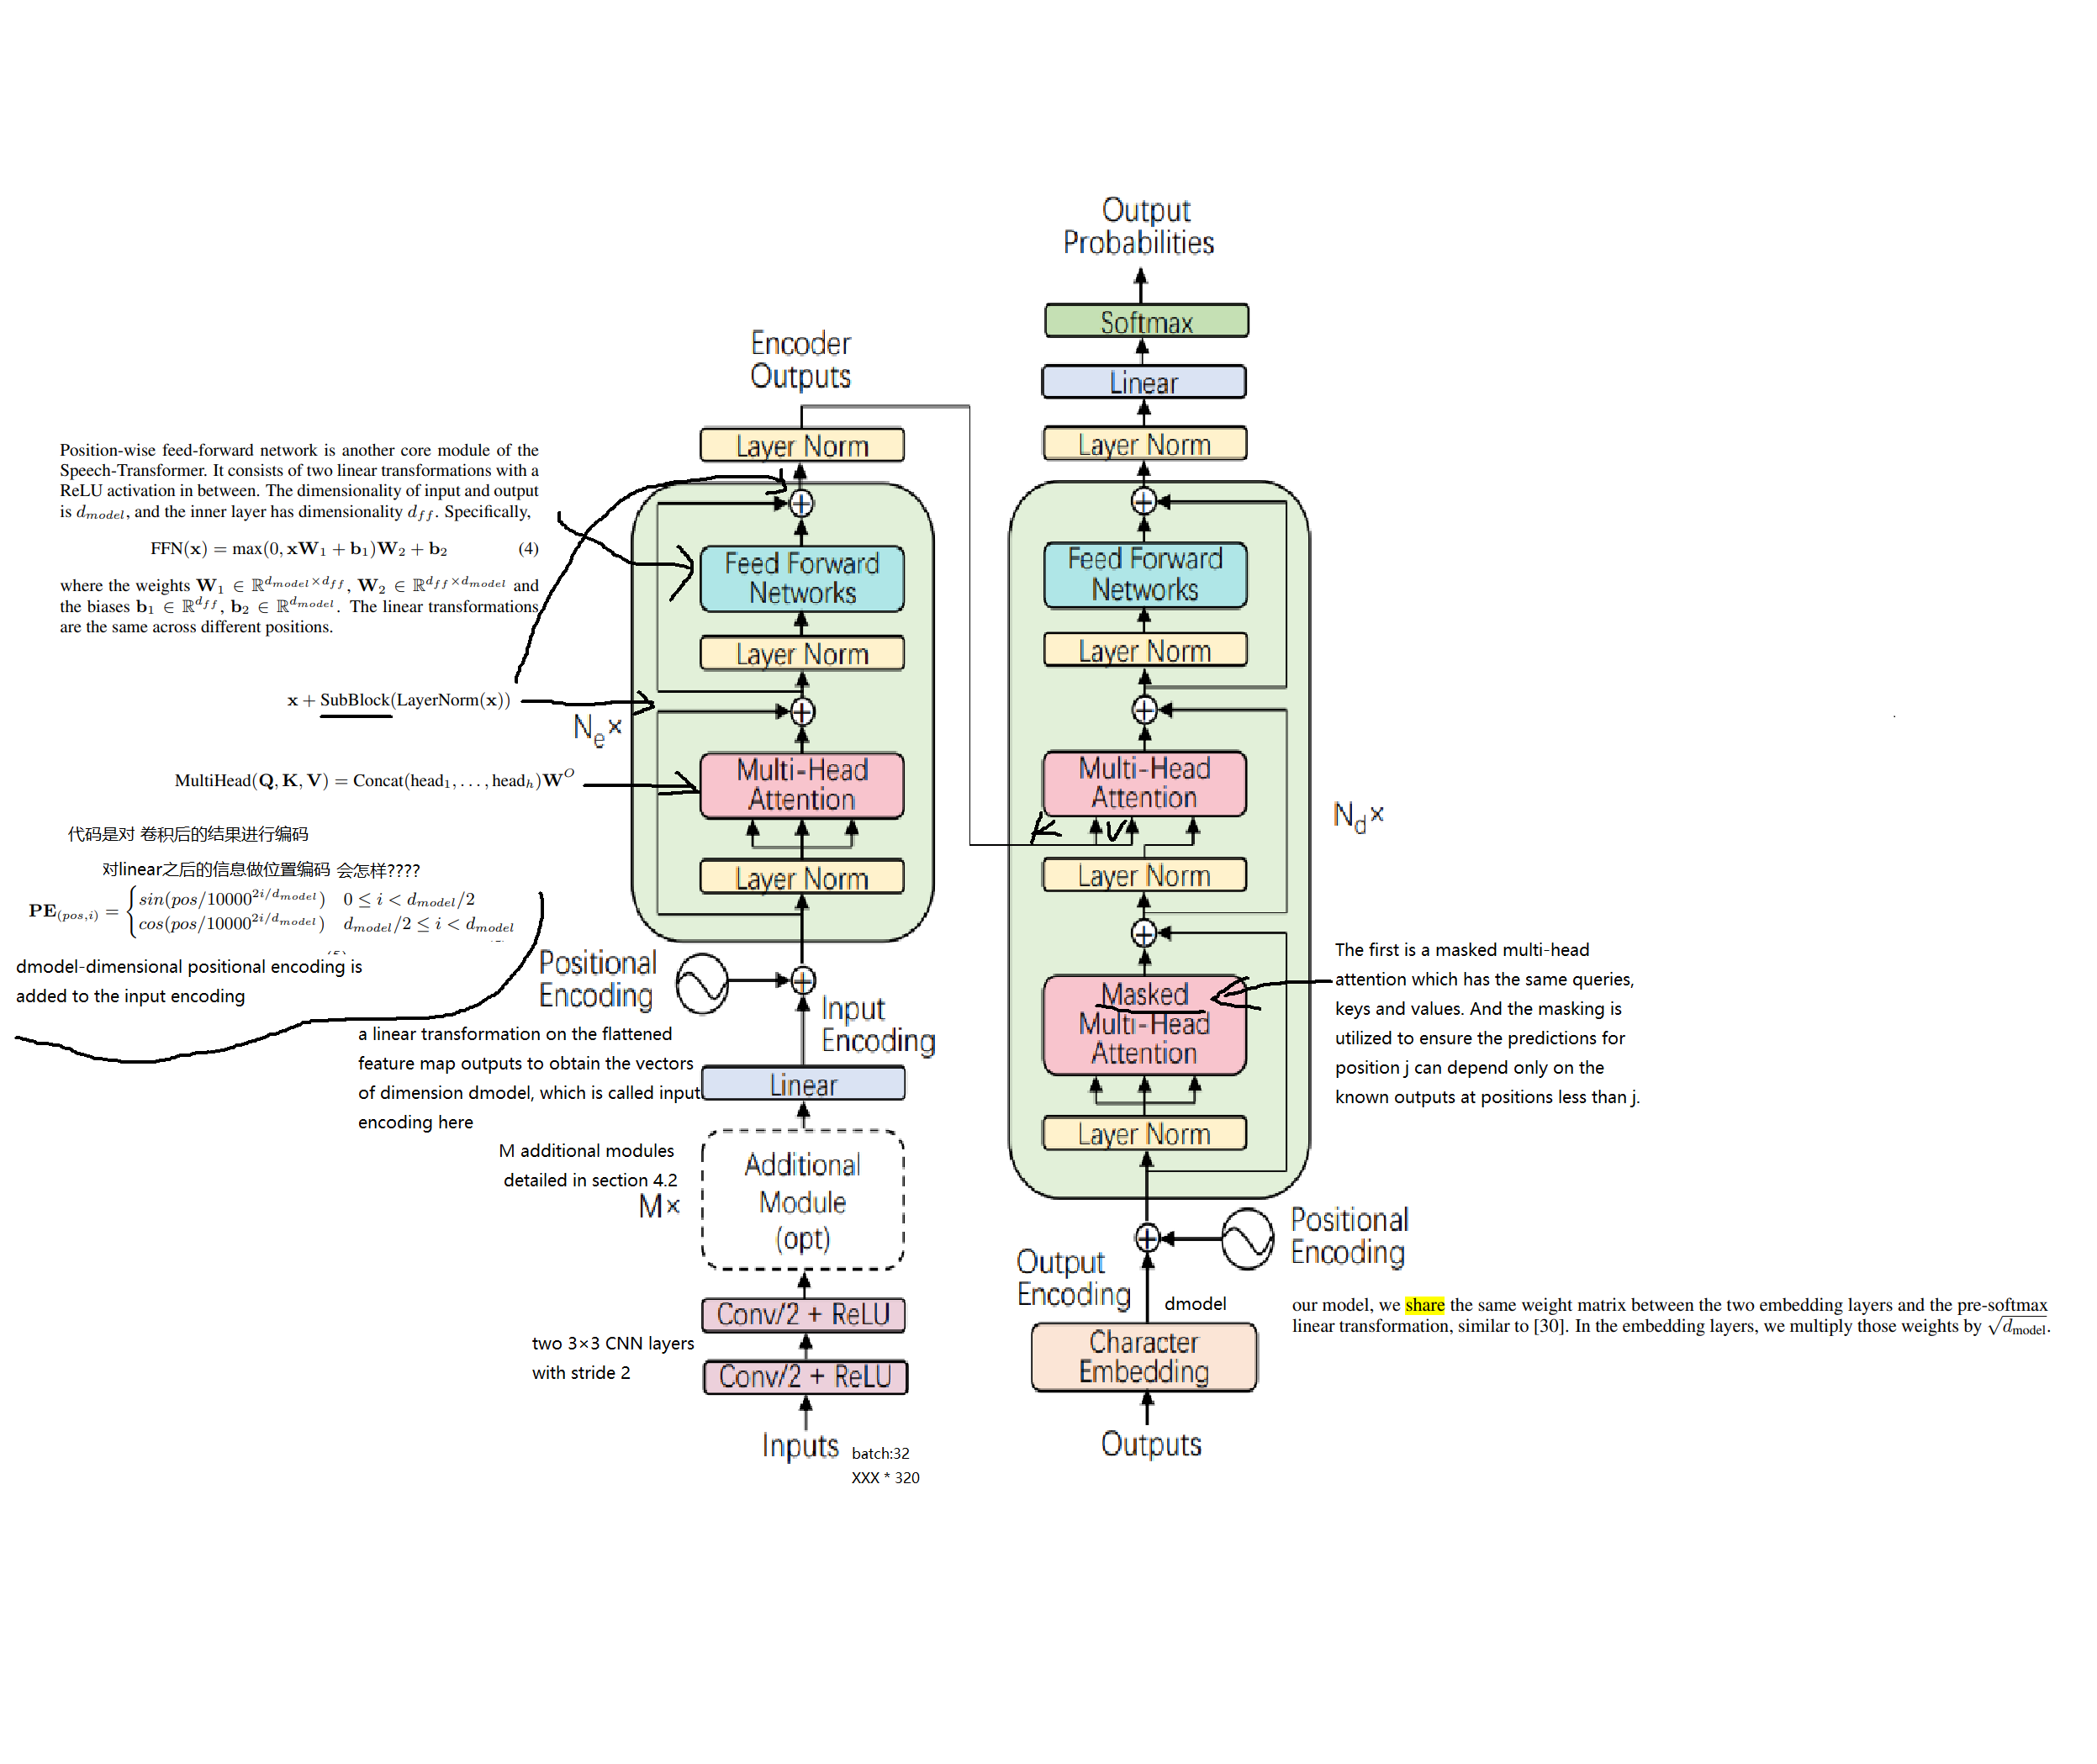

多头注意力机制

QKV
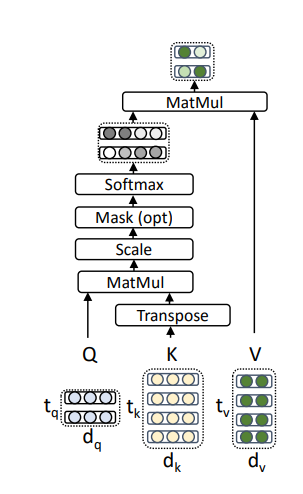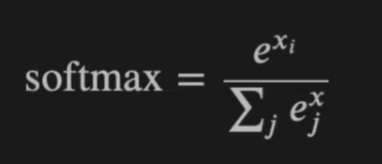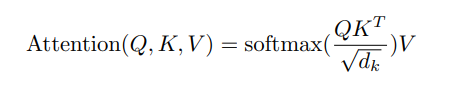

In [23]:
import torch.nn.functional as F
# mask传入的是一个矩阵,需要mask的位置是-inf,不需要mask的位置是0
def scaled_dot_product_attention(q, k, v, mask=None):
    # q:32,8,300,64
    # k:32,8,300,64
    # v:32,8,300,64
    # mask:300,300
    d_k=q.shape[-1]
    scaled=torch.matmul(q,k.transpose(-2,-1))/np.sqrt(d_k)#32,8,300,300
    if mask is not None:
        # torch自动补充
        scaled = scaled.permute(1, 0, 3, 2) + mask       
        scaled = scaled.permute(1, 0, 3, 2)
    attention =  F.softmax(scaled,dim=-1)
    values=torch.matmul(attention,v)
    return values,attention

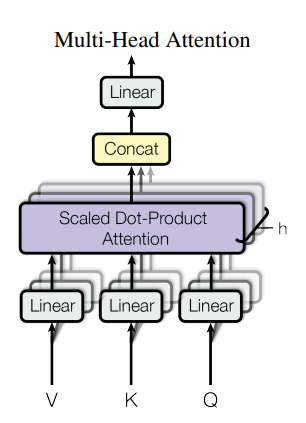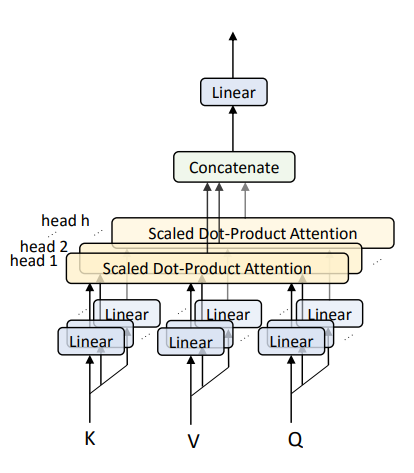

In [24]:
import torch.nn as nn
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask):
        batch_size, max_sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        if mask is not None:
            values, attention = scaled_dot_product_attention(q, k, v, mask[:,:x.size(1), :])
        else:
            values, attention = scaled_dot_product_attention(q, k, v, None)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)#32,200,512
        # 上图中linear
        out = self.linear_layer(values)
        return out

位置编码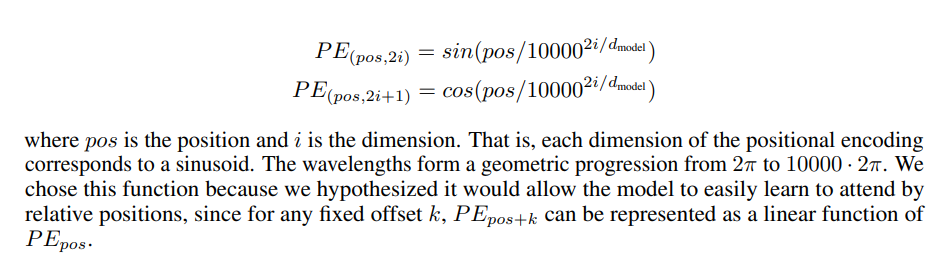

In [25]:
# 返回位置编码
class PositionalEncoding(nn.Module):

    def __init__(self, d_model):
        super(PositionalEncoding,self).__init__()
        self.d_model = d_model
    def forward(self,x):
        # even_i是偶数的位置
        even_i = torch.arange(0, self.d_model, 2).float()
        # denominator是分母
        denominator = torch.pow(10000, even_i/self.d_model)
        position = torch.arange(x.size(1)).reshape(x.size(1), 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        # stacked是将两个矩阵按照第三个维度拼接
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        # PE的维度是max_sequence_length*d_model
        PE = torch.flatten(stacked, start_dim=1, end_dim=2).to(device)
        x = x + PE[:x.size(1), :]
        return x

编码器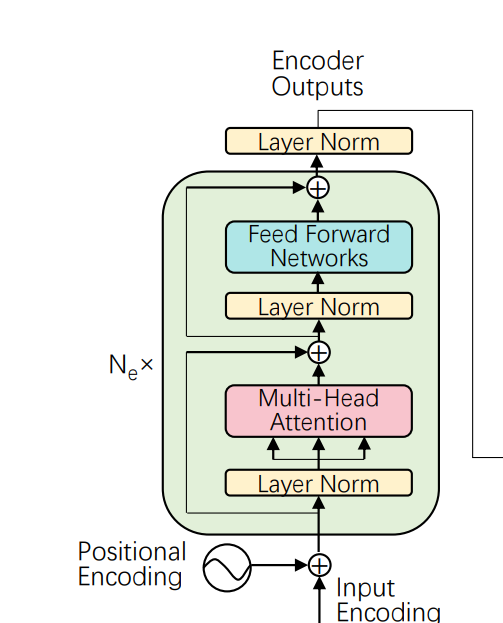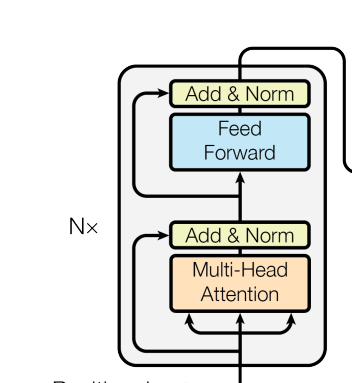

In [26]:
d_model=512
d_input=320
num_heads=8
drop_prob=0.1
batch_size=16
# # 语音是时间序列,最长300
# max_sequence_length=50
# feedforward神经网络的隐藏层维度
ffn_hidden=2048
num_layers=6

nn.LayerNorm:
> batch, sentence_length, embedding_dim = 20, 5, 10
>
> embedding = torch.randn(batch, sentence_length, embedding_dim)
>
> layer_norm = nn.LayerNorm(embedding_dim)

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
import torch.nn as nn
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)   #512->2048
        self.linear2 = nn.Linear(hidden, d_model)   #2048->512
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [29]:
class EncoderLayer(nn.Module):
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob):
        super(EncoderLayer,self).__init__()
        self.attention=MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        self.norm1=nn.LayerNorm(d_model)
        self.droupout1=nn.Dropout(drop_prob)
        self.ffn=PositionwiseFeedForward(d_model=d_model,hidden=ffn_hidden,drop_prob=drop_prob)
        self.norm2=nn.LayerNorm(d_model)
        self.droupout2=nn.Dropout(drop_prob)
    def forward(self,x):
        residual_x=x
        x=self.attention(x,mask=None)
        x=self.droupout1(x)
        x=self.norm1(x+residual_x)
        residual_x=x
        x=self.ffn(x)
        x=self.droupout2(x)
        x=self.norm2(x+residual_x)
        return x

In [30]:
# 编码器包括了输入线性变换到d_model维度
# 编码器是先多头再归一化

class Encoder(nn.Module):
    def __init__(self,d_input,d_model,ffn_hidden,num_heads,drop_prob,num_layers):
        super(Encoder,self).__init__()
        self.linear_in = nn.Linear(d_input, d_model)
        self.position_encoder = PositionalEncoding(d_model)
        self.layers=nn.Sequential(*[EncoderLayer(d_model,ffn_hidden,num_heads,drop_prob) for _ in range(num_layers)])
    def forward(self,x):
        x=self.linear_in(x)
        x=self.position_encoder(x).to(device)
        return self.layers(x)

In [31]:
encoder=Encoder(d_input,d_model,ffn_hidden,num_heads,drop_prob,num_layers)
enresult=encoder.forward(batch[0])
enresult.shape

torch.Size([32, 282, 512])

解码器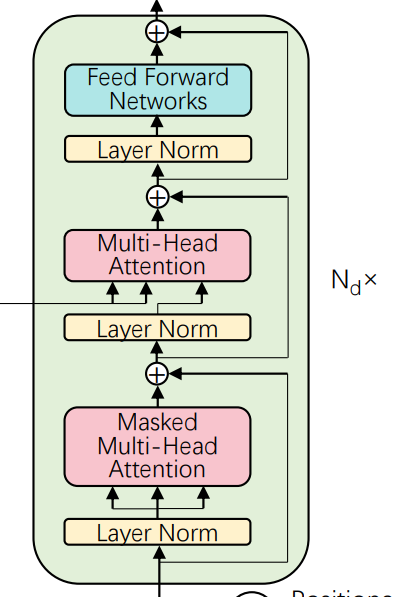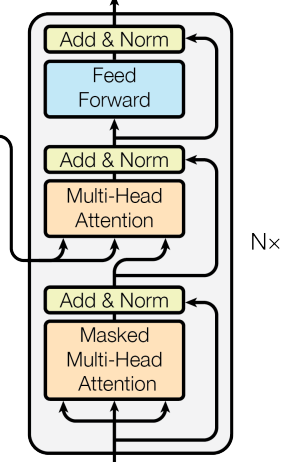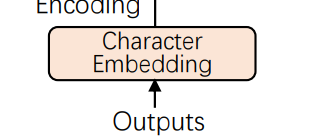


中国矿业大学  ->编码器|                   中国矿业大学  ->编码器|                        中国矿业大学  ->编码器|
                   ↓                                       ↓                                             ↓ 
<SOS>        ->解码器|--->C              <SOS>C       ->解码器|--->U                   <SOS>       ->解码器|   -->CUMT

In [32]:
len(char_list)

4336

In [33]:
# 返回的是加上位置编码的输入
class EmbeddingPosition(nn.Module):
    # language_to_index是一个字典,包含所有字的索引,传入char_list
    def __init__(self, max_sequence_length, d_model, language_to_index,START_TOKEN, END_TOKEN, PADDING_TOKEN):
        super().__init__()
        self.vocab_size = len(language_to_index)
        self.max_sequence_length = max_sequence_length
        self.embedding = nn.Embedding(self.vocab_size, d_model)
        self.language_to_index = language_to_index
        self.position_encoder = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(p=0.1)
        self.START_TOKEN = START_TOKEN
        self.END_TOKEN = END_TOKEN
        self.PADDING_TOKEN = PADDING_TOKEN
    def batch_tokenize(self, batch, start_token, end_token):
        def tokenize(sentence, start_token, end_token):
            sentence_word_indicies = [self.language_to_index[token] for token in list(sentence)]
            if start_token:
                sentence_word_indicies.insert(0, self.language_to_index[self.START_TOKEN])
            if end_token:
                sentence_word_indicies.append(self.language_to_index[self.END_TOKEN])
            for _ in range(len(sentence_word_indicies), self.max_sequence_length):
                sentence_word_indicies.append(self.language_to_index[self.PADDING_TOKEN])
            return torch.tensor(sentence_word_indicies)
        tokenized = []
        for sentence_num in range(len(batch)):
           tokenized.append( tokenize(batch[sentence_num], start_token, end_token) )
        tokenized = torch.stack(tokenized)
        return tokenized.to(device)
    def forward(self, x,start_token, end_token): 
        x = self.batch_tokenize(x, start_token, end_token)
        x = self.embedding(x)
        x = self.position_encoder(x).to(device)
        x = self.dropout(x)
        return x


In [34]:
d_model=512
d_input=320
num_heads=8
drop_prob=0.1
batch_size=16
# 语音是时间序列,最长300
max_sequence_length=200
# feedforward神经网络的隐藏层维度
ffn_hidden=2048
num_layers=6

In [35]:
from config import NEG_INF
def create_masks(batch):
    num_sentences = len(batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    
    for idx in range(len(batch)):
      sentence_length =len(batch[idx])
      chars_to_padding_mask = np.arange(sentence_length + 1, max_sequence_length)
      decoder_padding_mask_self_attention[idx, :, chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, chars_to_padding_mask, :] = True
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INF, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INF, 0)
    return decoder_self_attention_mask,decoder_cross_attention_mask

In [36]:
decoder_self_attention_mask,decoder_cross_attention_mask=create_masks(batch[1])
print(decoder_self_attention_mask.shape)
print(decoder_cross_attention_mask.shape)
print(decoder_self_attention_mask[0])
print(decoder_cross_attention_mask[0])

torch.Size([32, 200, 200])
torch.Size([32, 200, 200])
tensor([[ 0.0000e+00, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        ...,
        [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09]])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
         -1.0000e+09, -1.0000e+09],
     

编码器传入KV值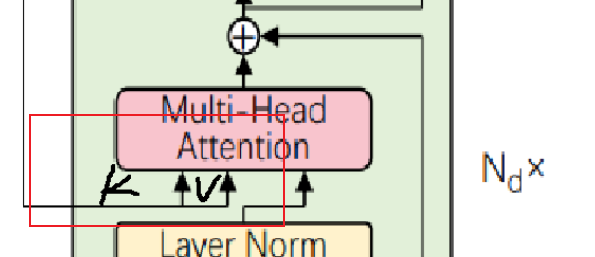

In [37]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model)#512->1024
        self.q_layer = nn.Linear(d_model , d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, y):
        batch_size, sequence_length, d_model = x.size() #30*300*512
        kv = self.kv_layer(x)#30*300*1024
        q = self.q_layer(y)#30*300*512
        kv = kv.reshape(batch_size,sequence_length, self.num_heads, 2 * self.head_dim)#30*500*8*128
        q = q.reshape(batch_size,  y.size(1), self.num_heads, self.head_dim)#30*300*8*64
        kv = kv.permute(0, 2, 1, 3)#30*8*300*128
        q = q.permute(0, 2, 1, 3)#30*8*300*64
        k, v = kv.chunk(2, dim=-1)#K:30*8*300*64 V:30*8*300*64
        # print(k.shape)
        # print(q.shape)
        values, attention = scaled_dot_product_attention(q, k, v,mask=None)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, y.size(1), d_model)
        out = self.linear_layer(values)
        return out

In [38]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.mask_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, self_attention_mask):
        _y = y.clone()  #只是为了加法
        # 解码器需要mask
        y = self.mask_attention(y, mask=self_attention_mask)
        y = self.dropout1(y)
        y = self.layer_norm1(y + _y)

        _y = y.clone()
        y = self.encoder_decoder_attention(x, y)
        y = self.dropout2(y)
        y = self.layer_norm2(y + _y)

        _y = y.clone()
        y = self.ffn(y)
        y = self.dropout3(y)
        y = self.layer_norm3(y + _y)
        return y

In [39]:
# 解码器的正向传播输入参数是多个,需要重写
class SequentialDecoder(nn.Sequential):
    def forward(self,*inputs):
        x,y,self_attention_mask =inputs
        for module in self._modules.values():
            y=module(x,y,self_attention_mask)
        return y

In [40]:
class Decoder(nn.Module):
    def __init__(self,d_model,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN):
        super(Decoder,self).__init__()
        # 词语嵌入
        self.embedding = EmbeddingPosition(max_sequence_length, d_model, language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.layers=SequentialDecoder(*[DecoderLayer(d_model,ffn_hidden,num_heads,drop_prob) for _ in range(num_layers)])
    def forward(self,x,y,self_attention_mask,start_token,end_token):
        # x:32*300*512
        # y:32*300*512
        # mask:300*300
        y = self.embedding(y, start_token, end_token)
        y=self.layers(x,y,self_attention_mask)
        return y 

In [41]:
START_TOKEN='<sos>'
END_TOKEN='<eos>'
PADDING_TOKEN='<PAD>'

In [42]:
decoder=Decoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,number_list,START_TOKEN=START_TOKEN,END_TOKEN=END_TOKEN,PADDING_TOKEN=PADDING_TOKEN)
decoder_self_attention_mask,decoder_cross_attention_mask=create_masks(batch[1])
decoder.forward(enresult,batch[1],decoder_self_attention_mask,START_TOKEN,END_TOKEN).shape

torch.Size([32, 200, 512])

Transformer代码

In [43]:
class Transformer(nn.Module):
    def __init__(self,d_model,d_input,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN):
        super(Transformer,self).__init__()
        self.encoder=Encoder(d_input,d_model,ffn_hidden,num_heads,drop_prob,num_layers)
        self.decoder=Decoder(d_model,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,language_to_index,START_TOKEN,END_TOKEN,PADDING_TOKEN)
        self.linear=nn.Linear(d_model,len(language_to_index))
    def forward(self,x,y,de_mask,start_token,end_token):
        # 只有解码器注意力需要mask,de_cross_mask也是不需要传入
        x=self.encoder(x)
        y=self.decoder(x,y,de_mask,start_token,end_token)
        y=self.linear(y)
        return y

In [44]:
transformer=Transformer(d_model,d_input,ffn_hidden,num_heads,drop_prob,num_layers,max_sequence_length,number_list,START_TOKEN=START_TOKEN,END_TOKEN=END_TOKEN,PADDING_TOKEN=PADDING_TOKEN)

In [45]:
wave = batch[0][0]
trn = ("",)
wave = torch.unsqueeze(wave, 0)
print(wave.shape)


torch.Size([1, 282, 320])


In [46]:
decoder_self_attention_mask,decoder_cross_attention_mask=create_masks(trn)

In [47]:
transformer.forward(wave,trn,decoder_self_attention_mask,START_TOKEN,END_TOKEN).shape

torch.Size([1, 200, 4336])

In [48]:
transformer

Transformer(
  (encoder): Encoder(
    (linear_in): Linear(in_features=320, out_features=512, bias=True)
    (position_encoder): PositionalEncoding()
    (layers): Sequential(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (qkv_layer): Linear(in_features=512, out_features=1536, bias=True)
          (linear_layer): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (droupout1): Dropout(p=0.1, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (droupout2): Dropout(p=0.1, inplace=False)
      )
      (1): EncoderLayer(
        (attention): MultiHeadAttention

In [49]:
batch[1][0]

'城市综合交通体系规划应明确公共交通优先发展原则'

In [50]:
loss_fn = nn.CrossEntropyLoss(ignore_index=number_list[PADDING_TOKEN],reduction='none')
# 初始化优化器
for params in transformer.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
input_batch= batch[0]
target_batch = batch[1]
decoder_self_attention_mask, decoder_cross_attention_mask = create_masks(target_batch)

In [52]:
predicted_batch=transformer.forward(input_batch,target_batch,decoder_self_attention_mask,START_TOKEN,END_TOKEN)

In [53]:
# 错位预测
labels = transformer.decoder.embedding.batch_tokenize(target_batch, start_token=False, end_token=True)

In [54]:
print(predicted_batch.shape)
predicted_batch_number=torch.argmax(predicted_batch[0], axis=1)
print(predicted_batch_number.shape)

torch.Size([32, 200, 4336])
torch.Size([200])


In [55]:
print(labels.shape)

torch.Size([32, 200])


In [56]:
loss_fn = nn.CrossEntropyLoss(ignore_index=number_list[PADDING_TOKEN],reduction='none')

In [57]:
predicted_batch.shape

torch.Size([32, 200, 4336])

In [58]:
loss=loss_fn(predicted_batch.view(-1,len(number_list)).to(device),labels.view(-1)).to(device)

In [59]:
print(loss.sum())

tensor(4384.5283, grad_fn=<SumBackward0>)


In [60]:
valid_position = torch.where(labels.view(-1)== number_list[PADDING_TOKEN], False, True)

In [61]:
labels

tensor([[  66,    6,  715,  ...,    0,    0,    0],
        [ 686,   56,  487,  ...,    0,    0,    0],
        [2518, 1067,  836,  ...,    0,    0,    0],
        ...,
        [1076,  733,  500,  ...,    0,    0,    0],
        [  20,  803,  647,  ...,    0,    0,    0],
        [  48,  193,  150,  ...,    0,    0,    0]])

In [62]:
valid_position.sum()

tensor(515)

In [63]:
loss = loss.sum() / valid_position.sum()
print(loss)

tensor(8.5136, grad_fn=<DivBackward0>)


In [64]:
sample = samples[0]
wave = sample['wave']
trn = sample['trn']
feature = extract_feature(input_file=wave, feature='fbank', dim=d_feature, cmvn=True)
feature = build_LFR_features(feature, m=LFR_stack, n=LFR_skip)
feature = torch.from_numpy(feature)
feature = torch.unsqueeze(feature, 0).to(device)